## WELCOME TO IBM HR ATTRITION EXPLORATION AND PREDICTION KERNEL
NOTE: I'm not a native English Speaker, so sorry for any english mistakes

The main objective is to explore the data and create a model to predict the Attrition of IBM workers.

### The problem
We will explore and try to predict the Attrition of IBM HR Analytics data. <br> 

What Is Attrition?<br>
Attrition in business describes a gradual but deliberate reduction in staff numbers that occurs as employees retire or resign and are <b>not replaced</b>. The term is also sometimes used to describe the loss of customers or clients as they mature beyond a product or company's target market without being replaced by a younger generation.

Important: Attrition is one way a company can decrease labor costs without the disruption of layoffs.
 
 
### Questions
I will start with some questions that maybe will help me in exploration:
- What's the % of Attrition at HR IBM dataset?
- What's the distribution of Ages?
- What's the difference between Genders?
- The years of experience is important to Attrition ?
- The performance or job satisfaction distributions says anything about the Attrition?
- People that live far from the job, are more propense to Attrition?
- And many more questions that could help us to understand the data and get some insights.

### After EDA:
I will create a Pipeline to find the model that best fit the data;
Also, I will create a Hyperopt model to find the best parameters to predict the Attrition of workers;
______________________________________
<br>
- I hope you enjoy the Kernel. <br>
- If you think that it is useful for you, please votes and give me your feedback =)

In [2]:

import plotly.chart_studio as py

ModuleNotFoundError: No module named 'plotly.chart_studio'

## Importing libraries

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats 
import os

import matplotlib.pyplot as plt
import seaborn as sns 

# Standard plotly imports
# import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, KFold, cross_validate

#Models
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomTreesEmbedding

In [5]:
df_train = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [6]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2)
    
    return summary

def dummies(df, list_cols):
    for col in list_cols:
        df_dummies = pd.get_dummies(df[col], drop_first=True, 
                                    prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
        df.drop(col, axis=1, inplace=True)
        
    return df

def get_ratio(df, cat_col):
    attr_temp = pd.DataFrame(df.groupby([cat_col, 'Attrition'])['EmployeeNumber'].count().unstack('Attrition').reset_index())
    attr_temp['ratio'] = round(attr_temp['Yes'] / (attr_temp['Yes'] + attr_temp['No']) * 100,2)
    attr_temp = attr_temp[[cat_col, 'ratio']]
    
    return attr_temp

## Getting the summary of our data

In [8]:
summary = resumetable(df_train)

summary

Dataset Shape: (1470, 35)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Age,int64,0,43,41,49,37,5.14
1,Attrition,object,0,2,Yes,No,Yes,0.64
2,BusinessTravel,object,0,3,Travel_Rarely,Travel_Frequently,Travel_Rarely,1.14
3,DailyRate,int64,0,886,1102,279,1373,9.62
4,Department,object,0,3,Sales,Research & Development,Research & Development,1.12
5,DistanceFromHome,int64,0,29,1,8,2,4.36
6,Education,int64,0,5,2,1,2,2.02
7,EducationField,object,0,6,Life Sciences,Life Sciences,Other,2.05
8,EmployeeCount,int64,0,1,1,1,1,0.00
9,EmployeeNumber,int64,0,1470,1,2,4,10.52


Based on this first summary of data, we can see that we haven't any missing value and 3 columns have constant values.<br>
Before we continue, I will drop the constant features; <br>
It's very cool to see that we have a lot of categorical features!!! So we could have some interesting insights <br>
The shape of our data is (1470, 35) and the EmployeeNumber is the Id of our dataset. <br>
Also is important to note that entropy measure the data disorder of the each feature and it shows the information contained in this feature.

## Categorical features with maximum 10 unique values

In [9]:
# Categorical features
cat_cols = ['Over18', 'StandardHours', 'EmployeeCount', 'Gender', 'PerformanceRating', 
            'OverTime', 'MaritalStatus', 'Department', 'BusinessTravel', 'StockOptionLevel', 
            'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 
            'RelationshipSatisfaction', 'WorkLifeBalance', 'Education', 
            'JobLevel', 'EducationField', 'TrainingTimesLastYear', 
            'JobRole', 'NumCompaniesWorked']

# constant features
const_list = ['EmployeeCount',  'Over18',  'StandardHours']

## Dropping constant features

In [10]:
df_train.drop(const_list,axis=1, inplace=True)

## Visualizing the distribution of Data Types

In [11]:
print("DATA TYPES: ")
print(summary['dtypes'].value_counts())

DATA TYPES: 
int64     26
object     9
Name: dtypes, dtype: int64


- Nice, Now, we will start exploring the features

## I will take a look on Attrition features that is our Target 

The % distribution of Attrition features is: 
No     84.0
Yes    16.0
Name: Attrition, dtype: float64


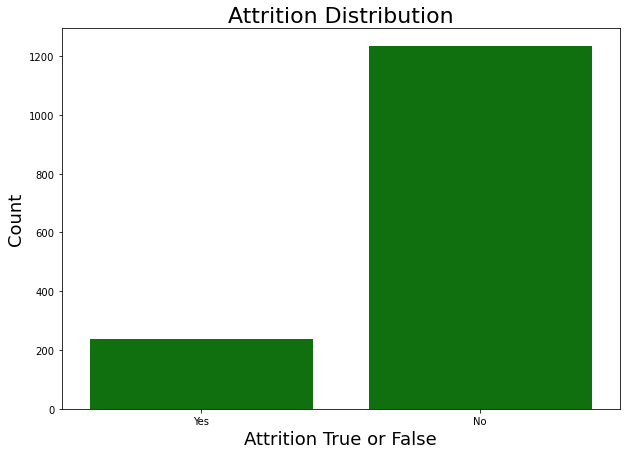

In [12]:
print("The % distribution of Attrition features is: ")
print(round(df_train['Attrition'].value_counts(normalize=True),2)*100)

plt.figure(figsize=(10,7))

g = sns.countplot(df_train["Attrition"], color='green')
g.set_title("Attrition Distribution", fontsize=22)
g.set_ylabel('Count', fontsize=18)
g.set_xlabel('Attrition True or False', fontsize=18)

plt.show()

Cool, we have 16% of true values of our target. It's a imbalanced data but nothing so terrible. <br>
Let's keep exploring the features to see wether we can get some insights about the IBM workers

## Plotting categorical features
- First, I will plot all features that has less than 11 values; I will do it, because categories with few values are easiest to explore.
- I will drop the constant columns and the Attrition feature.


In [13]:
## Filtering the constant features and the target 
cat_cols = [col for col in cat_cols if col not in (const_list +['Attrition'])]

## Categoricals by ATTRITION
-  Just features with maximum 10 values

UNDERSTANDING THE CATEGORICAL DISTRIBUTION BY THE TARGET (ATTRITION)
NOTE: - It's a plot just about the columns with maximum 10 values.


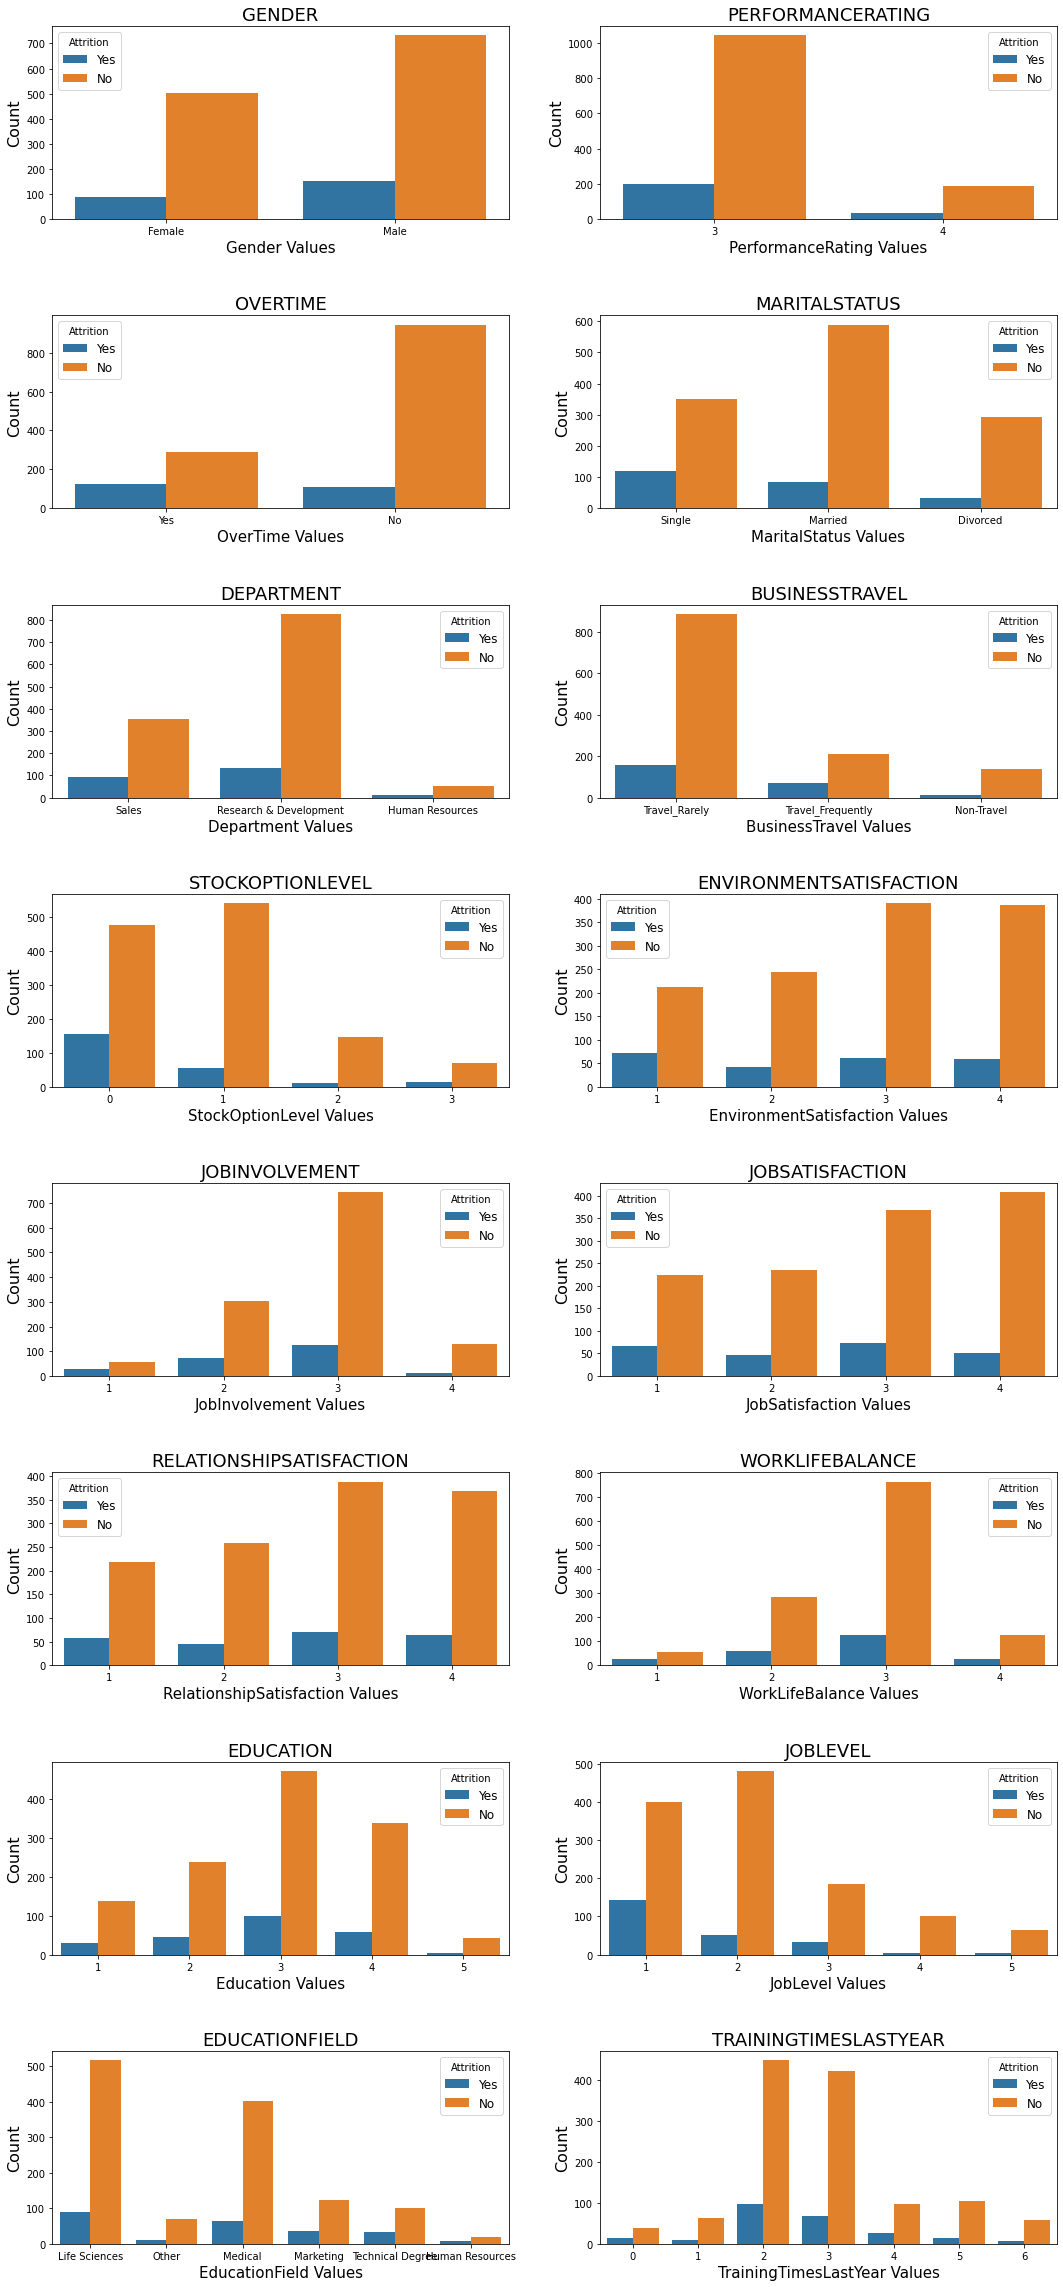

In [14]:
print("UNDERSTANDING THE CATEGORICAL DISTRIBUTION BY THE TARGET (ATTRITION)")
print("NOTE: - It's a plot just about the columns with maximum 10 values.")
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(18,35))
fig.subplots_adjust(hspace=0.5, bottom=0)
# fig.suptitle('BINARY FEATURES by the TARGET feature', fontsize=22)

for ax, catplot in zip(axes.flatten(), cat_cols):
        sns.countplot(x=catplot, data=df_train, hue='Attrition', ax=ax, )
        ## GEting the ratio of Years with current manager just to test into graphs
        ax.set_title(catplot.upper(), fontsize=18)
        ax.set_ylabel('Count', fontsize=16)
        ax.set_xlabel(f'{catplot} Values', fontsize=15)
        ax.legend(title='Attrition', fontsize=12)

# plt.tight_layout()

Cool!!! We can see that some features has a high chance to Attrition. <br>
Some features that we can see that the Attrition has different patterns is: stockoptionlevel,  performancerating, overtime, department, jobinvolvement

## Continuous and large categorical features
- Now I will explore the features with more than 10 values and try get some insights using the Attrition to see the different patterns

Minimum age on dataset is 18 and the maximum age is 60


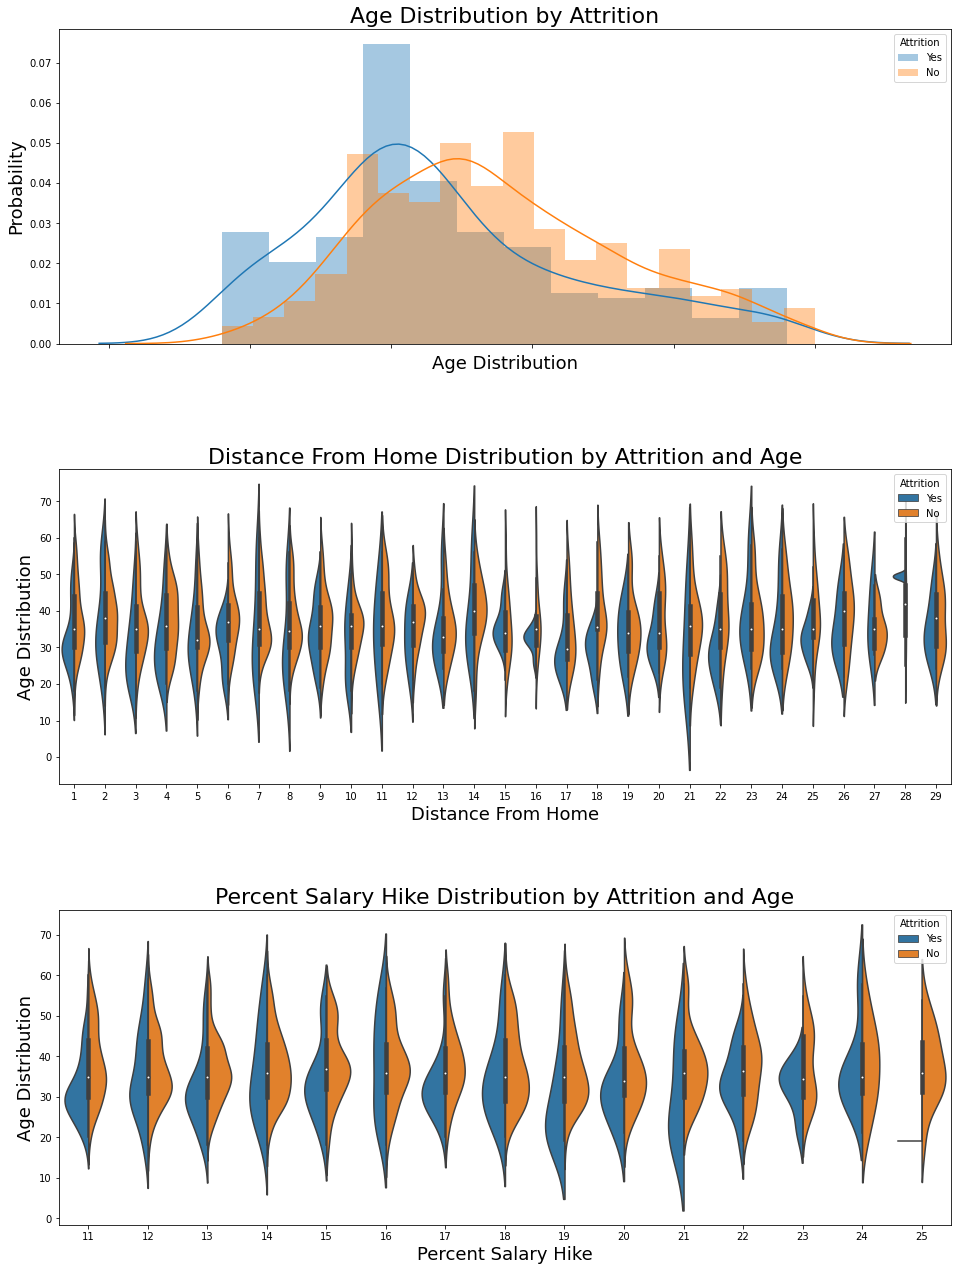

In [15]:
# PercentSalaryHike, DistanceFromHome, Age
print(f'Minimum age on dataset is {df_train["Age"].min()} and the maximum age is {df_train["Age"].max()}')
plt.figure(figsize=(16,22))

plt.subplot(3,1,1)
g = sns.distplot(df_train[df_train['Attrition'] == 'Yes']['Age'], label='Yes')
g = sns.distplot(df_train[df_train['Attrition'] == 'No']['Age'], label="No")
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.legend(title='Attrition')
g.set_title("Age Distribution by Attrition", fontsize=22)
g.set_xlabel("Age Distribution", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(3,1,2)
g1 = sns.violinplot(x='DistanceFromHome', y='Age', hue='Attrition', 
                    split=True, data=df_train, size=3)
g1.set_xticklabels(g1.get_xticklabels(),rotation=0)
g1.set_title("Distance From Home Distribution by Attrition and Age", fontsize=22)
g1.set_xlabel("Distance From Home", fontsize=18)
g1.set_ylabel("Age Distribution", fontsize=18)

plt.subplot(3,1,3)
g2 = sns.violinplot(x='PercentSalaryHike', y='Age',
                    split=True, hue='Attrition',data=df_train)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_title("Percent Salary Hike Distribution by Attrition and Age", fontsize=22)
g2.set_xlabel("Percent Salary Hike", fontsize=18)
g2.set_ylabel("Age Distribution", fontsize=18)

plt.subplots_adjust(hspace = 0.4)

plt.show()

Very insightful informations!! <br>
Based on charts we can see that the attrition is more probable in yougest people;

In [16]:
medimum_feats = ['PercentSalaryHike', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 
                 'YearsInCurrentRole', 'DistanceFromHome']
                 
big_feats = [ 'YearsAtCompany', 'TotalWorkingYears', 'Age','HourlyRate']

## Job Features

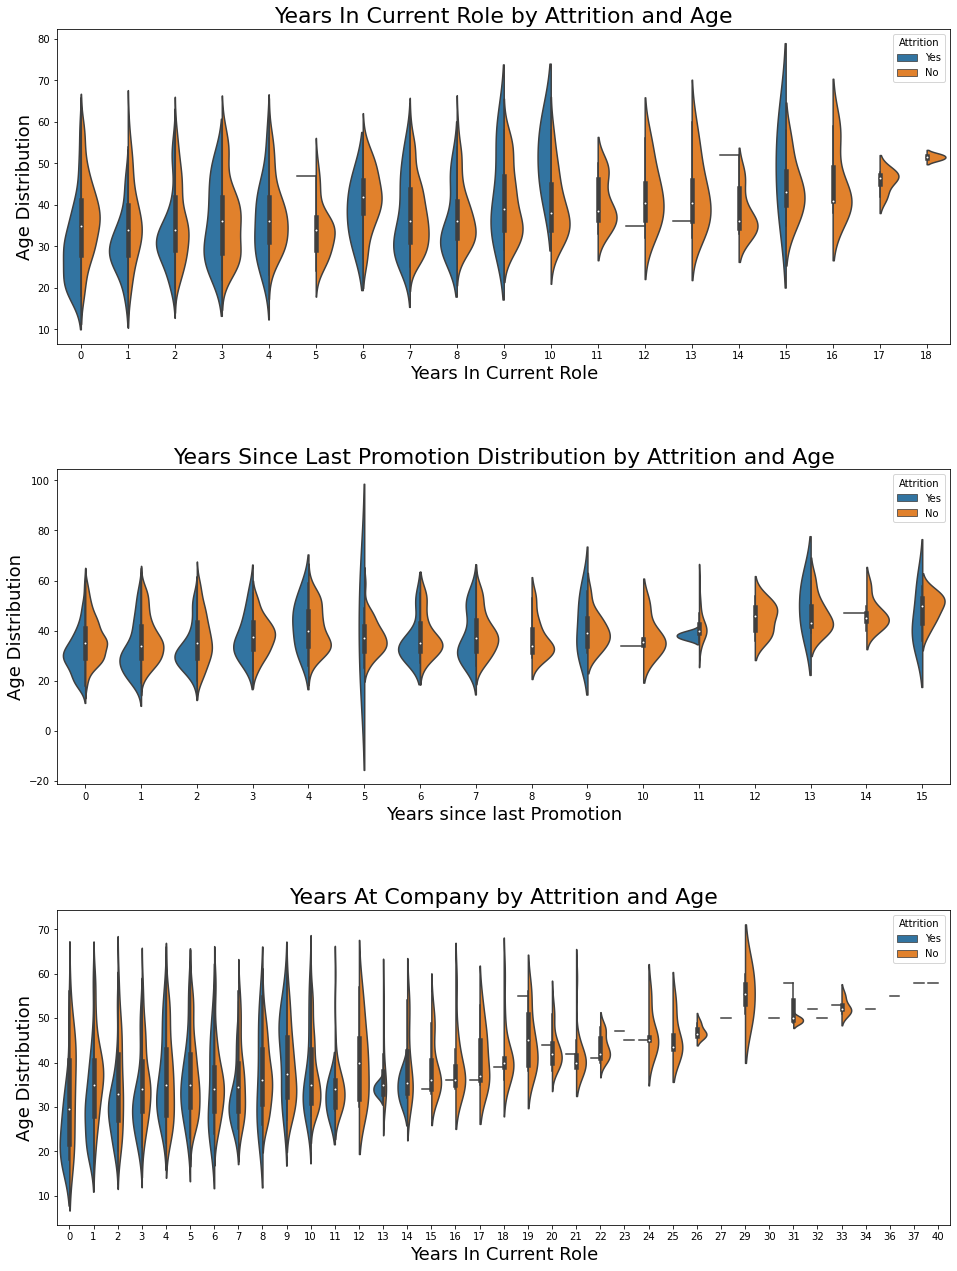

In [17]:
plt.figure(figsize=(16,22))

plt.subplot(3,1,1)
g = sns.violinplot(x='YearsInCurrentRole', y= 'Age', 
                   split=True, hue='Attrition', data=df_train)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title("Years In Current Role by Attrition and Age", fontsize=22)
g.set_xlabel("Years In Current Role", fontsize=18)
g.set_ylabel("Age Distribution", fontsize=18)

plt.subplot(3,1,2)
g1 = sns.violinplot(x='YearsSinceLastPromotion', y= 'Age', 
                    split=True, hue='Attrition', data=df_train)
g1.set_xticklabels(g1.get_xticklabels(),rotation=0)
g1.set_title("Years Since Last Promotion Distribution by Attrition and Age", fontsize=22)
g1.set_xlabel("Years since last Promotion", fontsize=18)
g1.set_ylabel("Age Distribution", fontsize=18)

plt.subplot(3,1,3)
g2 = sns.violinplot(x='YearsAtCompany', y= 'Age', 
                   split=True, hue='Attrition', data=df_train)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
g2.set_title("Years At Company by Attrition and Age", fontsize=22)
g2.set_xlabel("Years In Current Role", fontsize=18)
g2.set_ylabel("Age Distribution", fontsize=18)

plt.subplots_adjust(hspace = 0.4)

plt.show()

Cool. On Years at Company we can see that people with more than 12 years are less propense to leave the company.<br>
The same pattern we can see on Years in current Role... After 15 years in the current role, we don't have siginificant number of Attrition; 


## I will try some visuals with the Monthly Income

In [18]:
print(f"The minimum value Income in dataset is {df_train['MonthlyIncome'].min()} and maximum {df_train['MonthlyIncome'].max()}" )

The minimum value Income in dataset is 1009 and maximum 19999


In [19]:
print("Monthly Income Quantiles Distribution: ")
print(df_train['MonthlyIncome'].quantile([.01, .25, .5, .75, .99]))

Monthly Income Quantiles Distribution: 
0.01     1382.46
0.25     2911.00
0.50     4919.00
0.75     8379.00
0.99    19626.31
Name: MonthlyIncome, dtype: float64


In [20]:
def get_ratio(df, cat_col):
    attr_temp = df.groupby([cat_col, 'Attrition'])['EmployeeNumber'].count().unstack('Attrition').reset_index()
    attr_temp['ratio'] = round(attr_temp['Yes'] / (attr_temp['Yes'] + attr_temp['No']) * 100,2)
    attr_temp = attr_temp[[cat_col, 'ratio']]
    
    return attr_temp

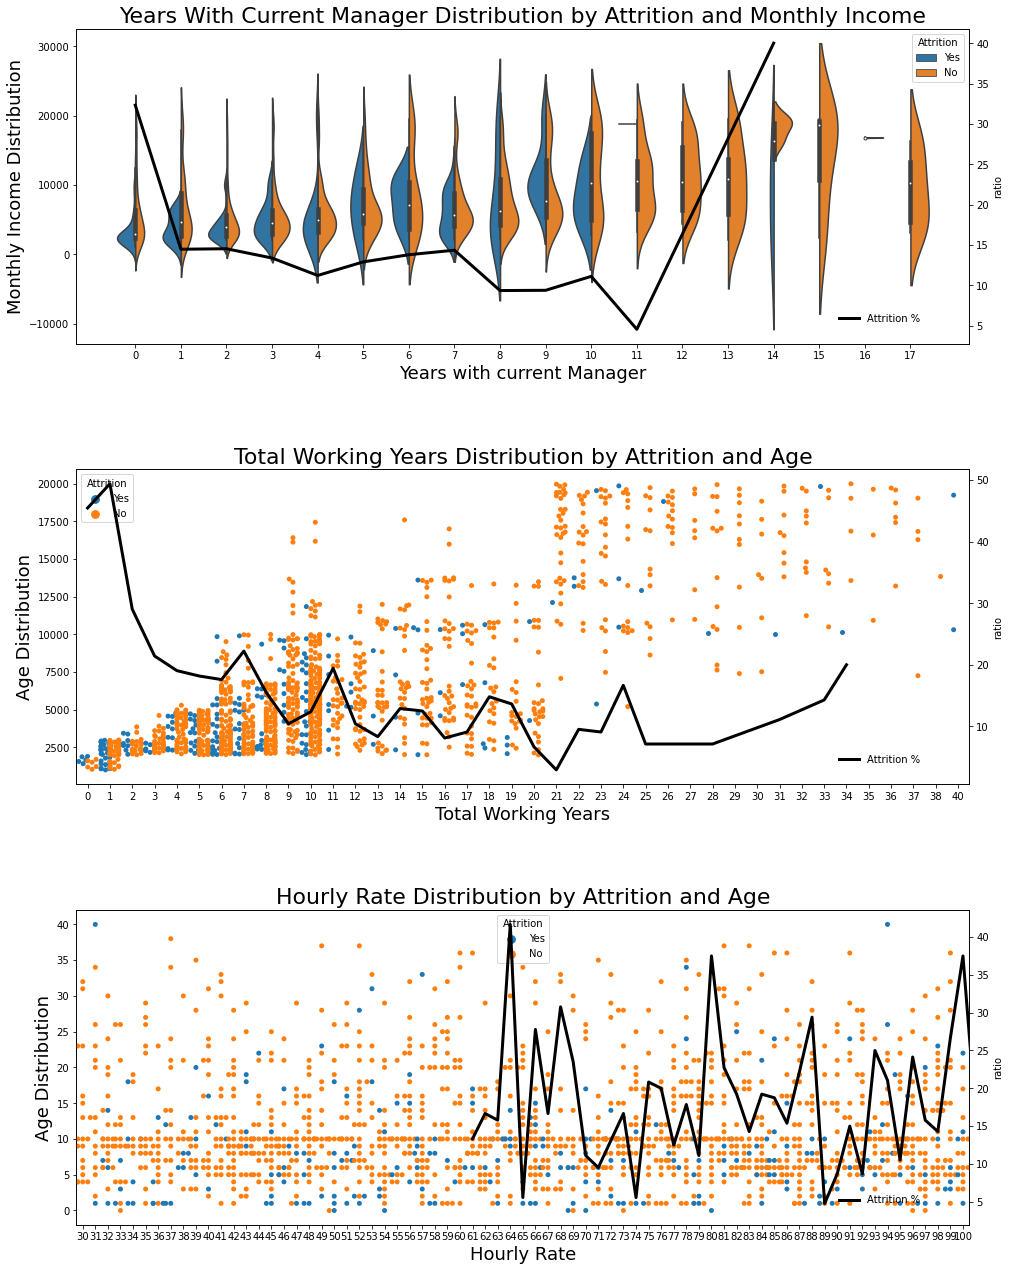

In [21]:
plt.figure(figsize=(16,22))

plt.subplot(3,1,1)

g = sns.violinplot(x='YearsWithCurrManager', y= 'MonthlyIncome', 
                    hue='Attrition',data=df_train, split=True)
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_title("Years With Current Manager Distribution by Attrition and Monthly Income", fontsize=22)
g.set_xlabel("Years with current Manager", fontsize=18)
g.set_ylabel("Monthly Income Distribution", fontsize=18)
ax2 = g.twinx()
attr_temp = get_ratio(df_train, 'YearsWithCurrManager')
gg = sns.lineplot(x='YearsWithCurrManager', y= 'ratio', ax=ax2, lw=3, markers='o',
             label="Attrition %", color='black',
             data=attr_temp)
gg.legend( loc = (.85, .05), frameon = False)


plt.subplot(3,1,2)
g1 = sns.swarmplot(x='TotalWorkingYears', y= 'MonthlyIncome', 
                    dodge=True, hue='Attrition', data=df_train)
ax3 = g1.twinx()
attr_temp = get_ratio(df_train, 'TotalWorkingYears')
gg = sns.lineplot(x='TotalWorkingYears', y= 'ratio', ax=ax3, lw=3, markers='o',
             label="Attrition %", color='black',
             data=attr_temp)
gg.legend( loc = (.85, .05), frameon = False)
g1.set_xticklabels(g1.get_xticklabels(),rotation=0)
g1.set_title("Total Working Years Distribution by Attrition and Age", fontsize=22)
g1.set_xlabel("Total Working Years", fontsize=18)
g1.set_ylabel("Age Distribution", fontsize=18)


plt.subplot(3,1,3)
g2 = sns.swarmplot(x='HourlyRate', y='TotalWorkingYears', hue='Attrition', data=df_train)
g2.set_title("Hourly Rate Distribution by Attrition and Age", fontsize=22)
g2.set_xlabel("Hourly Rate", fontsize=18)
g2.set_ylabel("Age Distribution", fontsize=18)
g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
ax4 = g2.twinx()
attr_temp = get_ratio(df_train, 'HourlyRate')
gg = sns.lineplot(x='HourlyRate', y= 'ratio', ax=ax4, lw=3, markers='o',
                  label="Attrition %", color='black',
                  data=attr_temp)

gg.legend( loc = (.85, .05), frameon = False)

plt.subplots_adjust(hspace = 0.4)

plt.show()

Very cool... This features are very meaningful and shows some patterns in Attrition; <br>
We can see a clear pattern in HourlyRate. 

## Monthly Income x Age by Attrition

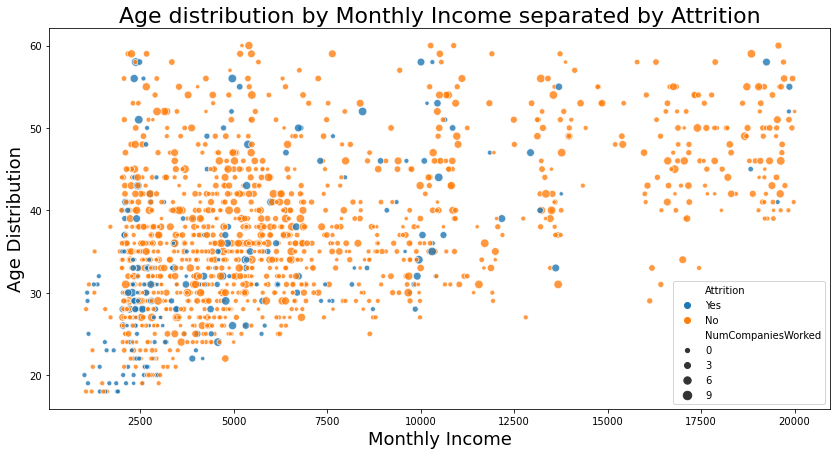

In [22]:
plt.figure(figsize=(14,7))

ax= sns.scatterplot(x='MonthlyIncome', y='Age', data=df_train, hue='Attrition', 
                    alpha=0.8, size=df_train['NumCompaniesWorked'])
ax.set_title("Age distribution by Monthly Income separated by Attrition", fontsize=22)
ax.set_xlabel("Monthly Income", fontsize=18)
ax.set_ylabel("Age Distribution", fontsize=18)

plt.show()

## Feature selection and Preprocessing

In [23]:
def LongDisWL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['WorkLifeBalance'] == 1 :
        return 1
    else : 
        return 0
    
def LongDisJobS1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobSatisfaction'] == 1 :
        return 1
    else : 
        return 0
    
def LongDisJL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobLevel'] == 1 :
        return 1
    else : 
        return 0
    
def ShortDisNotSingle(data) : 
    if  data['MaritalStatus'] != 'Single' and data['DistanceFromHome'] < 5:
        return 1
    else : 
        return 0
    
def LongDisSingle(data) : 
    if  data['MaritalStatus'] == 'Single' and data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
    
def Engaged(data) : 
    if data['Age'] > 35 and data['MaritalStatus'] != 'Single':
        return 1
    else : 
        return 0
    
def YoungAndBadPaid(data) : 
    if data['Age'] < 35 and data['Age'] > 23 and (data['MonthlyIncome'] < 3500):
        return 1
    else : 
        return 0
    
def YoungNeverEngaged(data) : 
    if data['Age'] < 24 and data['MaritalStatus'] == 'Single' :
        return 1
    else : 
        return 0    
    

## Feature engineering

In [24]:
## This features I get from the  amazing kernel of Vicent Lugat
## https://www.kaggle.com/kernels/scriptcontent/10006574/notebook

df_train['sales_dep'] = [1 if val == 'Sales' else 0 for val in df_train['Department']]
df_train['JobInvolvCut'] = [1 if val < 2.5 else 0 for val in df_train['JobInvolvement']]
df_train['MiddleTraining'] = [1 if (val  >= 3 and val <= 6) else 0 for val in df_train['TrainingTimesLastYear']]
df_train['MoovingPeople'] = [1 if (val  >4) else 0 for val in df_train['NumCompaniesWorked']]
df_train['MiddleTraining'] = [1 if (val  >= 3 and val <= 6) else 0 for val in df_train['TrainingTimesLastYear']]

df_train['TotalSatisfaction_mean'] = (df_train['RelationshipSatisfaction'] \
                                      + df_train['EnvironmentSatisfaction'] \
                                      + df_train['JobSatisfaction'] \
                                      + df_train['JobInvolvement'] \
                                      + df_train['WorkLifeBalance']) / 5

df_train['NotSatif'] = [1 if val < 2.35 else 0 for val in df_train['TotalSatisfaction_mean']]
df_train['LongDisWL1'] = df_train.apply(lambda data:LongDisWL1(data) ,axis = 1)
df_train['LongDis'] = [1 if val > 11 else 0 for val in df_train['DistanceFromHome']]
df_train['LongDisJobS1'] = df_train.apply(lambda data: LongDisJobS1(data) ,axis = 1)
df_train['LongDisJL1'] = df_train.apply(lambda data:LongDisJL1(data) ,axis = 1)
df_train['ShortDisNotSingle'] = df_train.apply(lambda data:ShortDisNotSingle(data) ,axis = 1)
df_train['LongDisSingle'] = df_train.apply(lambda data:LongDisSingle(data) ,axis = 1)
df_train['Engaged'] = df_train.apply(lambda data:Engaged(data) ,axis = 1)
df_train['YoungAndBadPaid'] = df_train.apply(lambda data:YoungAndBadPaid(data) ,axis = 1)
df_train['YoungNeverEngaged'] = df_train.apply(lambda data:YoungNeverEngaged(data) ,axis = 1)

df_train['Time_in_each_comp'] = (df_train['Age'] - 20) / ((df_train)['NumCompaniesWorked'] + 1)
df_train['RelSatisf_mean'] = (df_train['RelationshipSatisfaction']  + df_train['EnvironmentSatisfaction']) / 2
df_train['JobSatisf_mean'] = (df_train['JobSatisfaction'] + df_train['JobInvolvement']) / 2
df_train['Income_Distance'] = df_train['MonthlyIncome'] / df_train['DistanceFromHome']
df_train['Hrate_Mrate'] = df_train['HourlyRate'] / df_train['MonthlyRate']
df_train['Stability'] = df_train['YearsInCurrentRole'] / df_train['YearsAtCompany']
df_train['Stability'].fillna((df_train['Stability'].mean()), inplace=True)
df_train['Income_YearsComp'] = df_train['MonthlyIncome'] / df_train['YearsAtCompany']
df_train['Income_YearsComp'] = df_train['Income_YearsComp'].replace(np.Inf, 0)
df_train['Fidelity'] = (df_train['NumCompaniesWorked']) / df_train['TotalWorkingYears']
df_train['Fidelity'] = df_train['Fidelity'].replace(np.Inf, 0)

def attr_ratio(df, col):
    attr = df.groupby([col, 'Attrition'])['EmployeeNumber'].nunique().unstack('Attrition').reset_index()
    attr['ratio'] =  attr['Yes'] / (attr['No'] + attr['Yes'])
    
    return attr

## Preprocessing 

In [25]:
#customer id col
Id_col = ['EmployeeNumber']

#Target columns
target_col = ["Attrition"]

#categorical columns
cat_cols = df_train.nunique()[df_train.nunique() <= 10].keys().tolist()
cat_cols = [x for x in cat_cols if x not in target_col]

#numerical columns
num_cols = [x for x in df_train.columns if x not in cat_cols + target_col + Id_col]

#Binary columns with 2 values
bin_cols = df_train.nunique()[df_train.nunique() == 2].keys().tolist()

#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [26]:
dict_binary_cols = {'Attrition':{'Yes':1, 'No':0}, 
                    'Gender':{'Female':0, 'Male':1}, 
                    'OverTime':{'Yes':1,'No':0}}
df_train.replace(dict_binary_cols, inplace=True)

In [27]:
nom_cats = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']
df_train = dummies(df_train, nom_cats)

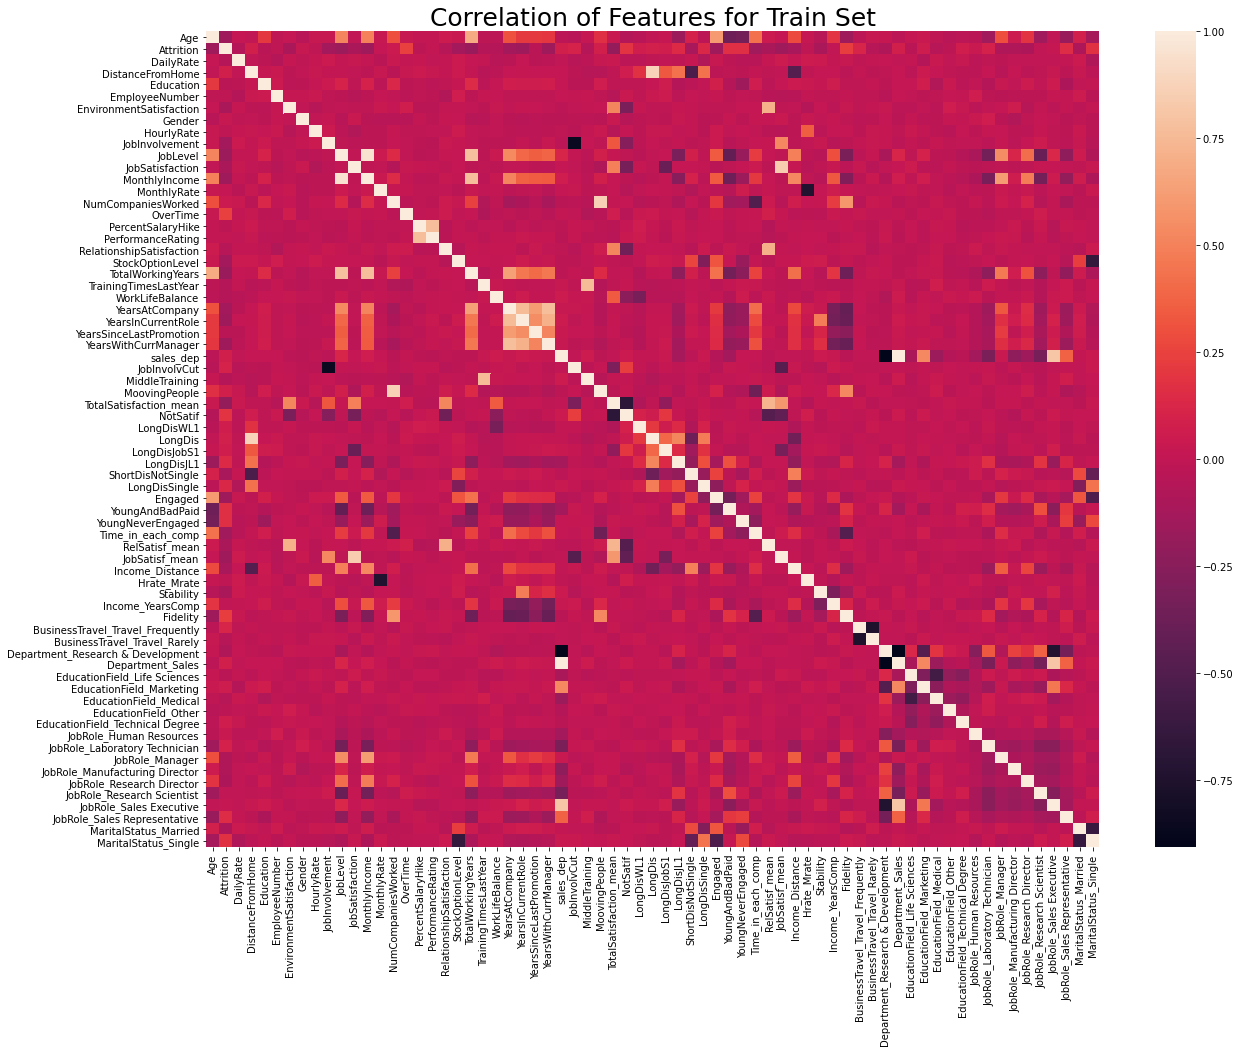

In [28]:
#Finallt, lets look the correlation of df_train
plt.figure(figsize=(20,15))
plt.title('Correlation of Features for Train Set', fontsize=25)
sns.heatmap(df_train.astype(float).corr(), vmax=1.0 )
plt.show()

In [30]:
# Threshold for removing correlated variables
threshold = 0.80

# Absolute value correlation matrix
corr_matrix = df_train.corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [31]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print(list(to_drop))

There are 8 columns to remove.
['MonthlyIncome', 'JobInvolvCut', 'MoovingPeople', 'LongDis', 'JobSatisf_mean', 'Department_Research & Development', 'Department_Sales', 'JobRole_Sales Executive']


In [32]:
df_train = df_train.drop(columns = to_drop)
print('Training shape: ', df_train.shape)

Training shape:  (1470, 61)


In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('Attrition', axis=1), df_train['Attrition'], test_size=.25)

## Creating the pipeline to compare classification algorithmns

LogReg: 0.880254 (+/- 0.035249)
XGBClassifier: 0.861229 (+/- 0.036716)
KNN: 0.844922 (+/- 0.036368)
DecisionTreeClassifier: 0.789599 (+/- 0.049198)
RandomForestClassifier: 0.853939 (+/- 0.032694)
GradientBoostingClassifier: 0.865725 (+/- 0.042693)
RidgeClassifier: 0.872998 (+/- 0.032339)
BaggingRidgeClassifier: 0.850287 (+/- 0.035189)
ExtraTreesClassifier: 0.861229 (+/- 0.039325)


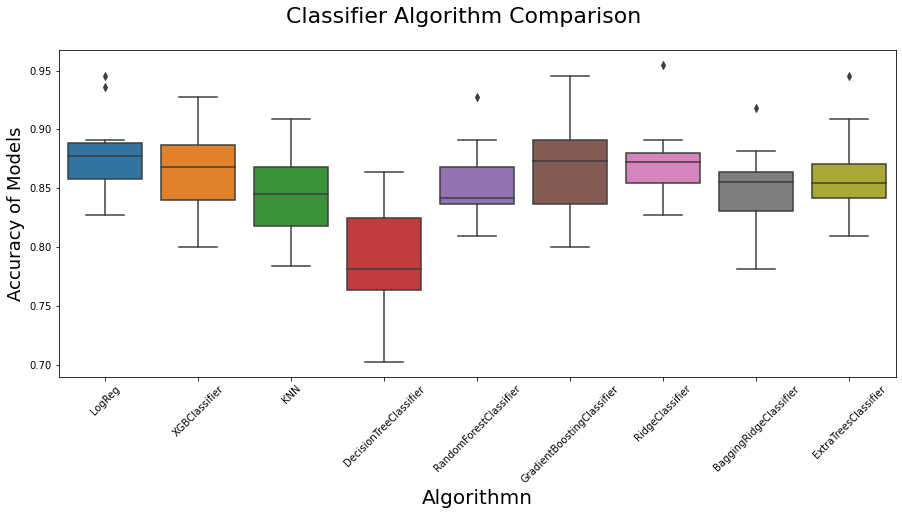

In [34]:
clfs = []
seed = 3

clfs.append(("LogReg", 
             Pipeline([("Scaler", StandardScaler()),
                       ("LogReg", LogisticRegression())])))

clfs.append(("XGBClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("XGB", XGBClassifier())]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier())]))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier())]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier())]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(max_features=15, 
                                                                       n_estimators=600))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier())])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier())])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier())])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'accuracy'
n_folds = 10

results, names  = [], [] 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  
                               cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

- Cool!!! Logistic Regression has the best result to predict Attriction. I will use a GLM algo to get soem insights and see the feature importanfces.

In [35]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 5, 25)


# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [36]:
import scipy as sp 
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def objective(params):
    clf = LogisticRegression(**params, solver='liblinear'
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=StratifiedKFold()).mean()
    print("Accuracy {:.8f} params {}".format(-score, params))
    return -score

space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C':  hp.choice('C', np.logspace(5, 10, 50))}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=150)

Accuracy -0.87661868 params {'C': 294705170.25518095, 'penalty': 'l1'}                                                 
Accuracy -0.87571370 params {'C': 91029817.79915227, 'penalty': 'l1'}                                                  
Accuracy -0.88024681 params {'C': 13894954.94373136, 'penalty': 'l2'}                                                  
Accuracy -0.87389963 params {'C': 954095476.3499963, 'penalty': 'l1'}                                                  
Accuracy -0.87571370 params {'C': 471486636.34573895, 'penalty': 'l1'}                                                 
Accuracy -0.88115179 params {'C': 655128.5568595509, 'penalty': 'l2'}                                                  
Accuracy -0.87661868 params {'C': 22229964.825261954, 'penalty': 'l1'}                                                 
Accuracy -0.87297408 params {'C': 202358.96477251555, 'penalty': 'l2'}                                                 
Accuracy -0.87661868 params {'C': 109854

Accuracy -0.87570136 params {'C': 954095476.3499963, 'penalty': 'l2'}                                                  
Accuracy -0.87479638 params {'C': 3088843596.4774847, 'penalty': 'l2'}                                                 
Accuracy -0.87570547 params {'C': 294705170.25518095, 'penalty': 'l2'}                                                 
Accuracy -0.88206088 params {'C': 100000.0, 'penalty': 'l2'}                                                           
Accuracy -0.87388318 params {'C': 372759372.0314938, 'penalty': 'l2'}                                                  
Accuracy -0.87933361 params {'C': 1048113.1341546853, 'penalty': 'l2'}                                                 
Accuracy -0.87842452 params {'C': 145634847.75012445, 'penalty': 'l2'}                                                 
Accuracy -0.87932538 params {'C': 2682695.7952797273, 'penalty': 'l2'}                                                 
Accuracy -0.87751131 params {'C': 115139

Accuracy -0.87661868 params {'C': 115139539.93264481, 'penalty': 'l1'}                                                 
Accuracy -0.87933361 params {'C': 1048113.1341546853, 'penalty': 'l2'}                                                 
Accuracy -0.88387084 params {'C': 2442053094.5486546, 'penalty': 'l2'}                                                 
Accuracy -0.87932538 params {'C': 2682695.7952797273, 'penalty': 'l2'}                                                 
Accuracy -0.87297408 params {'C': 202358.96477251555, 'penalty': 'l2'}                                                 
Accuracy -0.87661868 params {'C': 13894954.94373136, 'penalty': 'l1'}                                                  
Accuracy -0.88115590 params {'C': 255954.79226995332, 'penalty': 'l2'}                                                 
Accuracy -0.87932538 params {'C': 1930697728.8832457, 'penalty': 'l2'}                                                 
Accuracy -0.87842452 params {'C': 145634

In [37]:
best = {'C': 13894954.94373136, 'penalty': 'l2'}   

In [38]:
logreg = LogisticRegression(**best, solver='liblinear')

In [39]:
logreg.fit(X_train, y_train, )

LogisticRegression(C=13894954.94373136, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Testing our model in a unseen data

In [40]:
accuracy_score(y_val, logreg.predict(X_val))

0.8804347826086957

It's slightly better than the standard model that we used on Pipeline. 

Let's see the Auc and Confusion matrix to understand the classification 

In [42]:
from sklearn.metrics import classification_report
target_names = ['Yes', 'No']
print(classification_report(y_val, logreg.predict(X_val), target_names=target_names))

              precision    recall  f1-score   support

         Yes       0.91      0.96      0.93       315
          No       0.63      0.42      0.50        53

    accuracy                           0.88       368
   macro avg       0.77      0.69      0.72       368
weighted avg       0.87      0.88      0.87       368



## Confusion matrix

Confusion matrix, without normalization: 
[[302  13]
 [ 31  22]]
Normalized confusion matrix: 
[[0.96 0.04]
 [0.58 0.42]]


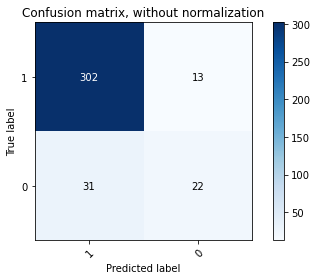

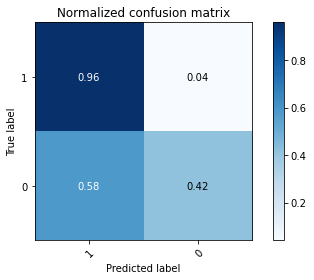

In [43]:
class_names = df_train['Attrition'].unique()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix: ")
    else:
        print('Confusion matrix, without normalization: ')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, logreg.predict(X_val), classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, logreg.predict(X_val), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## NOTE: I am working on this kernel, it's not finished yet.
If you liked, don't forget to votes up the kernel !!! =) 